In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import numpy as np
matplotlib.use('nbagg')

def display_plot(G, pos, size=50):
    nx.draw_networkx(G, pos, node_size=size, with_labels=False)
    plt.draw()
    plt.show()

def normalize(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    dist = l2
    l2[l2==0] = 1
    return dist, a / np.expand_dims(l2, axis)

def div0(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0
    return c

np.random.seed(1)

### Eades' Algorithm

<IPython.core.display.Javascript object>


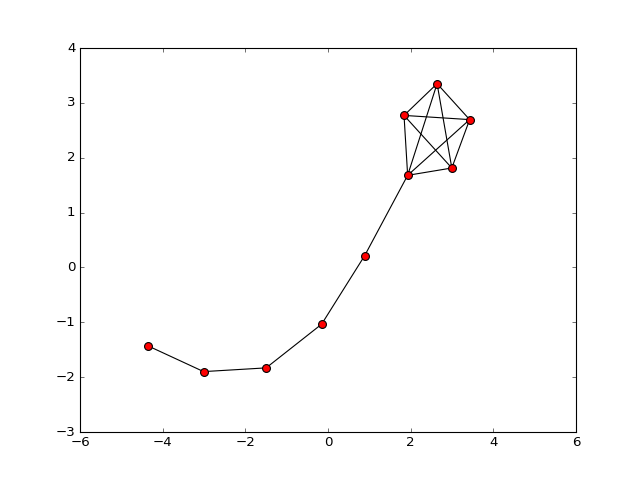

In [3]:
class Eades:
    '''
    A simple spring 2D layout model for graphs with up to 30 vertices
    
    Peter Eades. A heuristic for graph drawing. Congressus Numerantium,
    42:149–160, 1984. 
    '''
    
    def __init__(self, G, c1=2., c2=1., c3=1., c4=0.1):
        self.G = G
        self.M = nx.to_scipy_sparse_matrix(G, dtype='f')

        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.c4 = c4

        self.N_nodes = self.M.shape[0]
        self.pos = np.random.random((self.N_nodes, 2))

    def run(self, iterations=100):
        assert iterations >= 1
        assert type(iterations) is int

        # encode point coordinates as complex numbers
        z = np.array([complex(p[0], p[1]) for p in self.pos])

        for _ in range(iterations):
            delta = z[..., np.newaxis] - z  # pairwise Δx and Δy
            distance = abs(delta)  # pairwise distance

            distance[distance == 0] = 1
            delta = div0(delta, distance)  # normalize delta vectors

            # all nodes exert a repulsive force on node i
            repulsion = np.multiply(self.c3 / np.square(distance), delta)

            # neighbor nodes exert an attractive force on node i
            attraction = -1.0 * self.c1 * np.multiply(np.log((distance) / self.c2), delta)
            attraction = np.multiply(attraction, self.M.toarray())

            disp = self.c4 * np.sum(np.add(repulsion, attraction), axis=1)
            z = np.add(z, disp)

        self.pos = np.array([np.real(z), np.imag(z)]).T
        
    def display(self):
        display_plot(self.G, dict(zip(G.nodes(), self.pos)))

G = nx.lollipop_graph(5, 5)
graph = Eades(G)
graph.run(iterations=100)
graph.display()

### Tutte's 1963 Barycentric Method

It took 27 iterations to converge


<IPython.core.display.Javascript object>


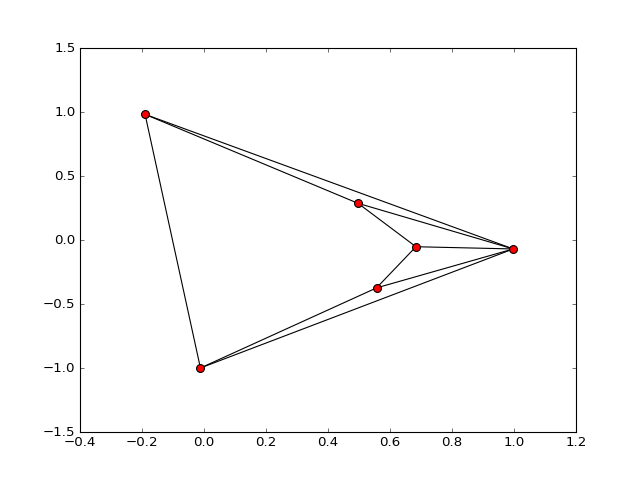

In [4]:
class Barycenter:
    '''
    Tutte's algorith for straight-line, crossings free drawings of
    3-connected planar graphs.

    William T. Tutte. How to draw a graph. Proc. London Math. Society,
    13(52):743–768, 1963
    '''

    def __init__(self, G, N_fixed=3):
        assert N_fixed == 3 # Currently only works with 3 fixed nodes

        self.G = G
        self.M = nx.to_scipy_sparse_matrix(G, dtype='f')
        
        self.N_nodes = self.M.shape[0]
        self.N_fixed = N_fixed
        self.N_free = self.N_nodes - N_fixed

        nodes = np.arange(self.N_nodes)
        self.pos = np.empty([self.N_nodes, 2])

        thetas = np.random.random_sample((self.N_fixed)) * 2.0 * np.pi
        np.sort(thetas)

        # plot fixed points on perimeter of unit circle
        # need to order k-cycle nodes in order
        for i in range(self.N_fixed):
            self.pos[i] = [np.cos(thetas[i]), np.sin(thetas[i])]

        self.degree = self.M.toarray().sum(axis=1).flatten()

    def run(self):
        converged = False
        self.iterations = 0

        while not converged:
            old_pos = np.copy(self.pos)

            for i in range(self.N_fixed, self.N_nodes):
                self.pos[i] = np.sum([self.pos[j] for j in self.M[i].indices], axis=0) / self.degree[i]

            self.iterations += 1
            converged = np.array_equal(old_pos, self.pos)

    def display(self):
        display_plot(self.G, dict(zip(G.nodes(), self.pos)))

# make a 3-connected undirected graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), 
                  (2, 3), (3, 4), (4, 5), (5, 6), (6, 2)])
graph = Barycenter(G, N_fixed=3)
graph.run()
print('It took {} iterations to converge'.format(graph.iterations))
graph.display()

### Fruchterman Reingold

<IPython.core.display.Javascript object>


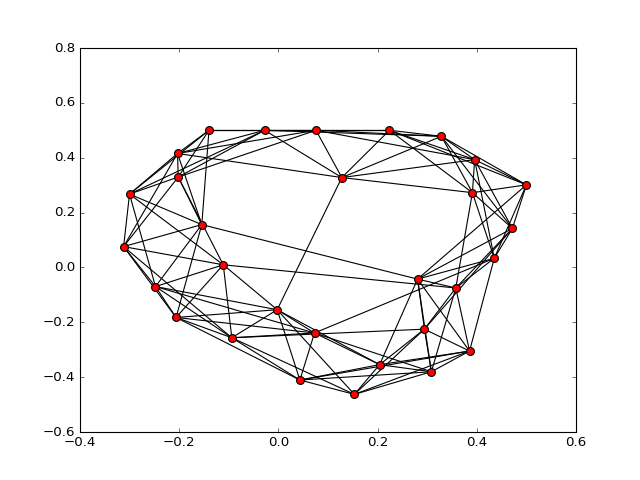

In [5]:
from networkx.readwrite import json_graph
import time

class FruchtermanReingold:
    '''
    T.M. Fruchterman, E.M. Reingold, Graph drawing by force-directed placement,
    Softw.: Pract. Exp. 21 (11) (1991) 1129–1164.
    '''
    
    def __init__(self, G, width=1.0, length=1.0, temperature=None, iterations=100):
        self.G = G
        self.M = nx.to_scipy_sparse_matrix(G, dtype='f')
        self.N_nodes = self.M.shape[0]

        self.pos = np.random.random((self.N_nodes, 2))
        
        self.width = float(width)
        self.length = float(length)
        self.area = self.width * self.length
        self.k = np.sqrt(self.area / self.N_nodes)

        self.temperature = temperature if temperature else self.width / 10

    def run(self, iterations=100):
        assert iterations >= 1
        assert type(iterations) is int
        
        t_curr = self.temperature
        dt = self.temperature / iterations
        
        for _ in range(iterations):
            # convert (x, y) positions to x+yj complex value
            z = np.array([complex(p[0], p[1]) for p in self.pos])

            delta = z[..., np.newaxis] - z  # pairwise Δx and Δy
            distance = abs(delta)  # pairwise distance
            distance[distance == 0] = 1  # for division convenience
            
            # all nodes exert a repulsive force on one another
            repulsion = self.k**2 * delta / distance**2
            
            # neighbor nodes exert an attractive force on one another
            attraction = -1.0 * distance * delta / self.k
            attraction = attraction * self.M.toarray()
            
            # sum the complex-valued displacement 'vectors' acting on each node
            # then make them real valued
            disp = np.sum(repulsion + attraction, axis=1)
            disp = np.array([np.real(disp), np.imag(disp)]).T

            # normalize displacement distances
            disp_dist, disp = normalize(disp)
            
            # move nodes, with temperature damping (simulated annealing)
            self.pos = self.pos + disp * np.minimum(disp_dist, t_curr)[:, np.newaxis]
            
            # ensure that the nodes remain within the box's area
            self.pos[:, 0] = np.minimum(self.width / 2, np.maximum(-1 * self.width / 2, self.pos[:, 0]))
            self.pos[:, 1] = np.minimum(self.length / 2, np.maximum(-1 * self.length / 2, self.pos[:, 1]))
            
            # cool off a bit, so later iterations produce less movement
            t_curr -= dt
            
    def display(self):
        display_plot(self.G, dict(zip(G.nodes(), self.pos)))

np.random.seed(1)

G = nx.watts_strogatz_graph(30, 8, 0.05, seed=81)

graph = FruchtermanReingold(G, width=1, length=1)
graph.run(100)
graph.display()
